### __Imports__

In [222]:
import math
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import random
from typing import List

### __Graphing__

In [223]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    # Creates a graphviz visualization of the computational graph
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    
    # Add nodes to graph
    for n in nodes:
        uid = str(id(n))
        # Node label: data value | operation
        label = f"{n.label} | data: {n.data:.4f} | grad: {n.grad:.4f}"
        dot.node(name=uid, label=label, shape='record')
        
        if n._op:
            # Add operation label with circle shape
            dot.node(name=uid + n._op, label=n._op, shape='circle')
            dot.edge(uid + n._op, uid)
    
    # Add edges to graph
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [224]:
def f(x):
    return 3*x**2 - 2*x + 1

In [225]:
f(3.0)

22.0

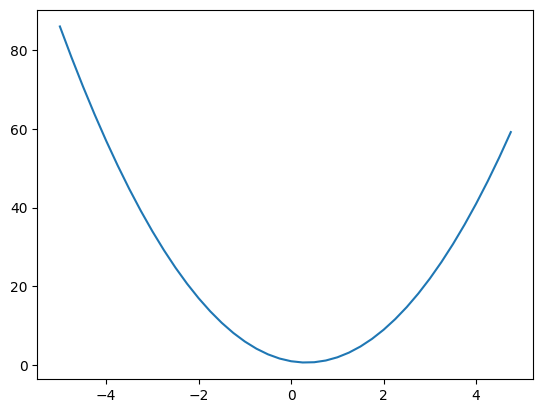

In [226]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [227]:
h = 0.00001
x = -3.0
(f(x + h) - f(x)) / h

-19.999970000128542

In [228]:
a = 2. 
b = -3.
c = 10.
d = a*b + c
print(d)

4.0


In [229]:
d1 = a*b + c
a += h
d2 = a*b + c
print(d2)

3.9999699999999994


In [230]:
(d2 - d1) / h

-3.000000000064062

In [231]:
a

a + b 
a * b

-6.000030000000001

### __Value Class__

In [232]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = _children
        self._op = _op
        self.label = label

    def __repr__(self):
        # if show_grad:
        return f"Value(data={self.data}, grad={self.grad})"
        # return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # def __sub__(self, other):
    #     out = Value(self.data.__add__(-1 * other.data), (self, other))
    #     return out
    # figure if this gets automatically handled or not
    # soln: neural nets don't need subtraction
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x_data = self.data
        t = math.tanh(x_data)
        out = Value(t, (self,), "tanh")
        return out

    def sigmoid(self):
        x_data = self.data
        t = 1 / (1 + math.exp(-x_data))
        out = Value(t, (self,), "sigmoid")
        return out
    
    def relu(self):
        x_data = self.data
        t = 0 if x_data <= 0 else x_data
        out = Value(t, (self,), "relu")
        return out
    
    def trace_back(self, node):
        if node._prev:
            if node._op == '+':
                node._prev[0].grad += node.grad * 1.0
                node._prev[1].grad += node.grad * 1.0
            else:
                node._prev[0].grad += node.grad * node._prev[1].data
                node._prev[1].grad += node.grad * node._prev[0].data

            node.trace_back(node._prev[0])
            node.trace_back(node._prev[1])

    def backward(self):
        self.grad = 1.0
        self.trace_back(self)

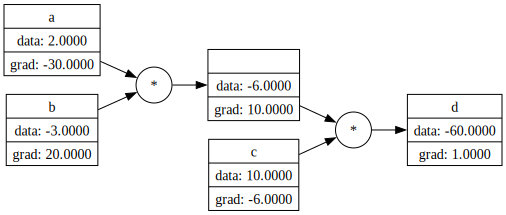

In [233]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b * c; d.label = 'd'
# print(d._prev)
# d._prev[0].label = 'ab'
# d._prev[0].backward()
d.backward()
# print(d.data)
draw_dot(d)

### __Neuron Class__

In [234]:
class Neuron:
    def __init__(self, n_units: int):
        self.weights =  [Value(random.gauss(0, 1)) for _ in range(n_units)]
        self.bias = Value(random.gauss(0, 1))
    
    def __repr__(self):
        return (
            f"Neuron:\n"
            f"  weights: {self.weights}\n"
            f"  bias: {self.bias}"
        )
    
    def forward(self, x: List[Value]) -> List[Value]:
        assert len(x) == len(self.weights), "Input vector's length must be equal to n_units of the neuron"
        res = Value(0.0)
        for i in range(len(x)):
            res += self.weights[i] * x[i]

        res += self.bias
        return res
    
    def __call__(self, x: List[Value]):
        return self.forward(x)

In [235]:
input_arr = [Value(1), Value(2), Value(3)]
n1 = Neuron(3)
n2 = Neuron(1)
n3 = Neuron(1)

print(n1)
print(n2)
print(n3)

Neuron:
  weights: [Value(data=0.6206000388841546, grad=0.0), Value(data=1.3017552257673342, grad=0.0), Value(data=-0.6100981910047562, grad=0.0)]
  bias: Value(data=-1.8912496276305881, grad=0.0)
Neuron:
  weights: [Value(data=-0.35075496134092926, grad=0.0)]
  bias: Value(data=0.8155328637519849, grad=0.0)
Neuron:
  weights: [Value(data=-0.13422388031726934, grad=0.0)]
  bias: Value(data=-0.42952832901229104, grad=0.0)


In [236]:
o1 = n1(input_arr)
print(o1)
o1_list = [o1]

o2 = n2(o1_list)
print(o2)
o2_list = [o2]

o3 = n3(o2_list)
print(o3)

Value(data=-0.49743371022603355, grad=0.0)
Value(data=0.9900102055519923, grad=0.0)
Value(data=-0.5624113403551769, grad=0.0)


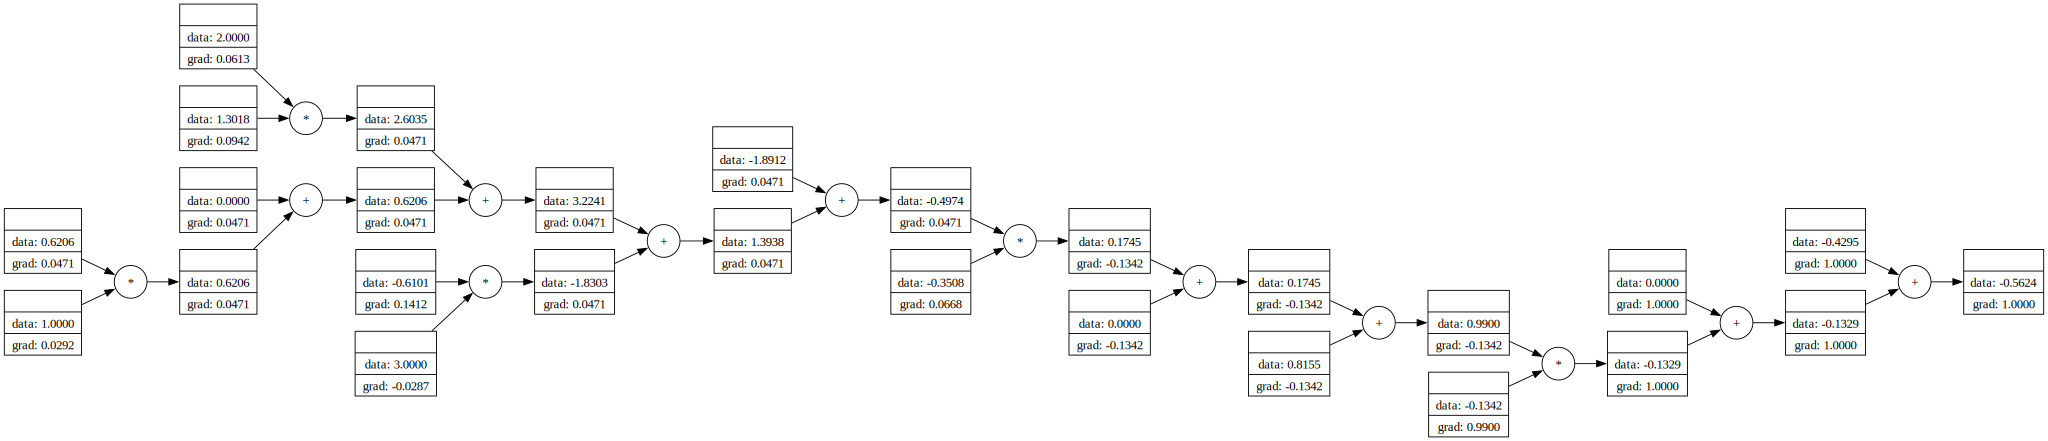

In [237]:
draw_dot(o3)
o3.backward()
draw_dot(o3)

In [238]:
n1

Neuron:
  weights: [Value(data=0.6206000388841546, grad=0.047079691951713326), Value(data=1.3017552257673342, grad=0.09415938390342665), Value(data=-0.6100981910047562, grad=0.14123907585513998)]
  bias: Value(data=-1.8912496276305881, grad=0.047079691951713326)

### __Layer Class__

In [239]:
class NeuronLayer:
    def __init__(self, in_features: int, out_features: int):
        self.in_features = in_features
        self.out_features = out_features
        self.layer = [Neuron(in_features) for _ in range(out_features)]
    
    def forward(self, x: List[Value]) -> List[Value]:
        assert len(x) == self.in_features, "Input vector's length must be equal to n_units of the neuron"
        res = []
        for i in range(self.out_features):
            neuron_i = self.layer[i]
            res_i = Value(0.0)
            for j in range(self.in_features):
                res_i += x[j] * neuron_i.weights[j]
            res_i += neuron_i.bias
            res.append(res_i)

        return res
    
    def __call__(self, x: List[Value]):
        return self.forward(x)

    def __repr__(self):
        out_str = "NeuronLayer:\n"
        for i in range(self.out_features):
            neuron = self.layer[i]
            # out_str += f"Neuron_{i+1}\n" + str(neuron) + "\n"
            out_str += str(neuron) + "\n"
        return out_str

In [240]:
lst = ["abc", "def", "ghi"]
print("\n".join(lst))

abc
def
ghi


In [241]:
str(n1)

'Neuron:\n  weights: [Value(data=0.6206000388841546, grad=0.047079691951713326), Value(data=1.3017552257673342, grad=0.09415938390342665), Value(data=-0.6100981910047562, grad=0.14123907585513998)]\n  bias: Value(data=-1.8912496276305881, grad=0.047079691951713326)'

In [242]:
input_arr

[Value(data=1, grad=0.02921765865588731),
 Value(data=2, grad=0.06128623502565913),
 Value(data=3, grad=-0.02872323489280148)]

In [243]:
layer = NeuronLayer(3, 2)
layer(input_arr)

[Value(data=-9.59704105444112, grad=0.0),
 Value(data=-5.873745976439777, grad=0.0)]

### __MLP Class__

In [244]:
class MLP:
    def __init__(self):
        self.layers: List[NeuronLayer] = []
    
    def add_layer(self, in_features: int, out_features: int):
        layer = NeuronLayer(in_features=in_features, out_features=out_features)
        self.layers.append(layer)
    
    def forward(self, x: List[Value]) -> List[Value]:
        out_l = x
        for i in range(len(self.layers)):
            curr_layer = self.layers[i]
            out_l = curr_layer(out_l)
        
        return out_l
    
    def __call__(self, x: List[Value]):
        return self.forward(x)
    
    def __repr__(self):
        out_str = "MLP:\n"
        for i in range(len(self.layers)):
            layer = self.layers[i]
            out_str += str(layer) + "\n"
        return out_str

In [245]:
mlp = MLP()
mlp.add_layer(3, 2)
mlp.add_layer(2, 1)
print(mlp)
mlp_res = mlp(input_arr)

MLP:
NeuronLayer:
Neuron:
  weights: [Value(data=-0.15221689457627668, grad=0.0), Value(data=-0.8382223569889153, grad=0.0), Value(data=-0.7254799377136417, grad=0.0)]
  bias: Value(data=0.31851434860207123, grad=0.0)
Neuron:
  weights: [Value(data=0.6657574622056377, grad=0.0), Value(data=-2.3426410853744613, grad=0.0), Value(data=-0.37655236109090623, grad=0.0)]
  bias: Value(data=-0.9402649761136771, grad=0.0)

NeuronLayer:
Neuron:
  weights: [Value(data=0.48103504602692504, grad=0.0), Value(data=0.04692476100557019, grad=0.0)]
  bias: Value(data=0.0168902289245743, grad=0.0)




In [246]:
draw_dot(mlp_res[0])
mlp_res[0].backward()

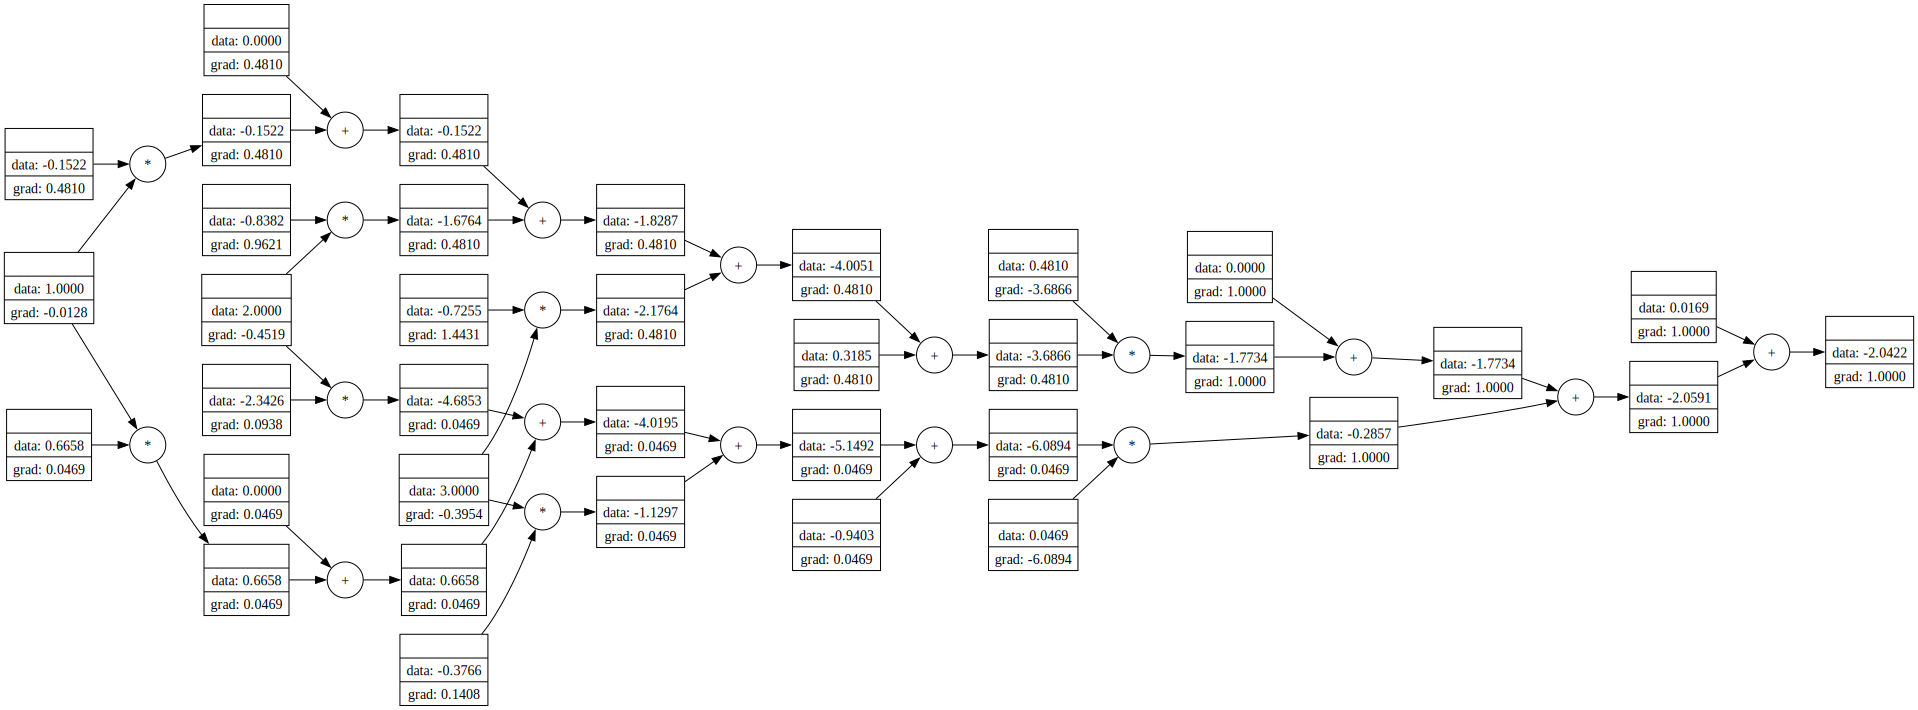

In [247]:
draw_dot(mlp_res[0])

In [248]:
k: float = 0
print(k)
print(type(k))

0
<class 'int'>


In [249]:
from math import tanh
tanh(3.5)

0.9981778976111987

### __Activation Functions__

In [250]:
# activation functions
def tanh(x: List[Value]) -> List[Value]:
    return [i.tanh() for i in x]

def relu(x: List[Value]) -> List[Value]:
    return [i.relu() for i in x]

def sigmoid(x: List[Value]) -> List[Value]:
    return [i.sigmoid() for i in x]

### __Activation Layer__

In [251]:
class ActivationLayer:
    def __init__(self, activation: str):
        activations = {
            "tanh": tanh,
            "relu": relu,
            "sigmoid": sigmoid
        }
        if activation not in activations:
            raise ValueError(f"Unsupported activation function: {activation}")
        
        self.activation = activations[activation]

    def __call__(self, x: List[Value]) -> List[Value]:
        return self.activation(x)

In [252]:
input_arr

[Value(data=1, grad=-0.012763492431013056),
 Value(data=2, grad=-0.45185596810232753),
 Value(data=3, grad=-0.3953741396727678)]

In [253]:
act = ActivationLayer("tanh")
act(input_arr)

[Value(data=0.7615941559557649, grad=0.0),
 Value(data=0.9640275800758169, grad=0.0),
 Value(data=0.9950547536867305, grad=0.0)]

### __Loss Functions__

In [ ]:
# loss functions

def MSELoss(y_pred: List[Value], y_target: List[Value]) -> Value:
    assert len(y_pred) == len(y_target), "Length of y_pred should be equal to that of y_target"
    loss = Value(0.0)
    m = len(y_pred)
    for i in range(len(y_pred)):
        diff = y_pred[i] - y_target[i]
        loss += diff * diff
    
    loss /= 2 * m
    return loss

# def CrossEntropyLoss(y_pred: List[Value], )


### __Optimizer Class__

In [ ]:
class Optimizer:
    def __init__(self, mlp_model: MLP):
        self.mlp = mlp_model
    
    def zero_grad(self):
        pass